In [14]:
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (15,7)

# Eredeti normál minta

In [2]:
true_mu = 3 # igazi átlag
true_sigma = 5 # igazi szorás

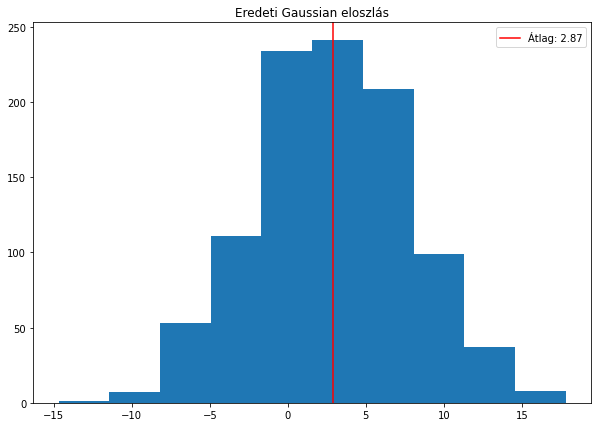

In [3]:
normal = np.random.normal(true_mu, true_sigma, 1000)
plt.clf()
plt.title("Eredeti Gaussian eloszlás")
plt.axvline(np.mean(normal), label=f"Átlag: {np.round(np.mean(normal), 2)}", color="red")
plt.hist(normal)
plt.legend()
plt.show()

# Cenzúrázot normál

## Adat

In [4]:
low = 0 # ami alatt minden mérés egyforma

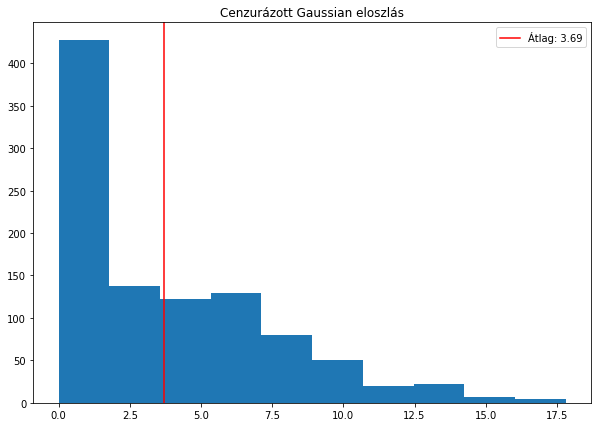

In [5]:
# cenzurázott adatok
censored = np.array([ i if i > low else low for i in normal ])
# ábra
plt.clf()
plt.title("Cenzurázott Gaussian eloszlás")
plt.axvline(np.mean(censored), label=f"Átlag: {np.round(np.mean(censored), 2)}", color="red")
plt.hist(censored)
plt.legend()
plt.show()

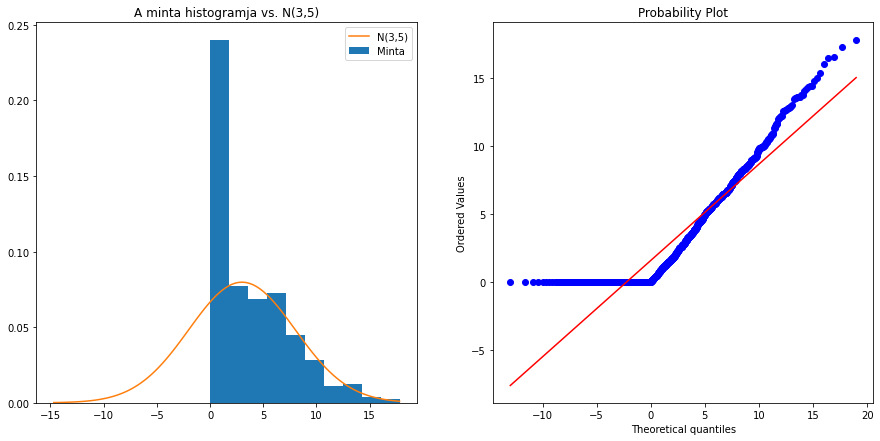

In [15]:
import scipy.stats as stats
# Histogram 
plt.subplot(1,2,1)
# minta
plt.hist(censored, density=True, label="Minta")
# standard normál pdf sűrűségfüggvénye 
bins = np.linspace(np.min(normal), np.max(normal), 100)
normalpdf = stats.norm.pdf(bins, true_mu, true_sigma)
plt.plot(bins, normalpdf, label=f"N({true_mu},{true_sigma})")
# jelmagyarázat és cím
plt.title(f"A minta histogramja vs. N({true_mu},{true_sigma})")
plt.legend()
 
# Q-Q ábra
plt.subplot(1,2,2)
stats.probplot(censored, dist="norm", sparams=(true_mu,true_sigma), plot=plt)
plt.show()

## Bayesian estimation

Source:
  * https://github.com/pymc-devs/pymc/issues/1833
  * https://docs.pymc.io/en/stable/pymc-examples/examples/survival_analysis/censored_data.html

In [7]:
# elemszám a minimum értékben
n_left_censored = sum(censored <= low)
# elemszám a Gaussian részben
n_observed = len(censored) - n_left_censored
# a nem cenzurázot megfigyelések 
uncensored = censored[(censored > low)]
assert len(uncensored) == n_observed

274


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\attila_sajo\miniconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 809 seconds.
The acceptance probability does not match the target. It is 0.8785984065114144, but should be close to 0.8. Try to increase the number of tuning steps.


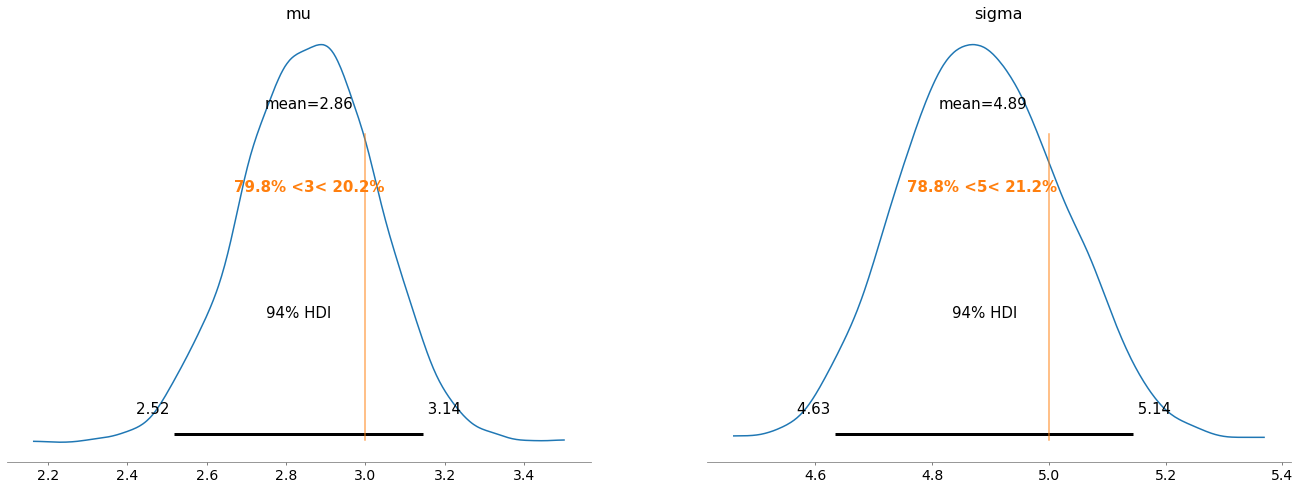

In [8]:
from pymc3.distributions.dist_math import normal_lccdf, normal_lcdf

high = np.max(censored)
# cenzurázott adatok log-likelihood-ja 
def left_censored_likelihood(mu, sigma, n_left_censored, lower_bound):
    """ Likelihood of left-censored data. """
    return n_left_censored  * normal_lcdf(mu, sigma, lower_bound)

# Model
with pm.Model() as censored_model:
    # kereset paraméterek priorja
    mu = pm.Uniform("mu", low, high)
    sigma = pm.Uniform("sigma", np.sqrt(np.var(uncensored))/2, 2*np.sqrt(np.var(uncensored)))
    
    # Gaussian megfigyelések
    observed = pm.Normal(
        "observed",
        mu=mu,
        sigma=sigma,
        observed=uncensored,
    )
    
    # cenzurázott megfigyelések
    left_censored = pm.Potential(
        "left_censored", left_censored_likelihood(mu, sigma, n_left_censored, low)
    )

# Mintavétel
with censored_model:
    trace = pm.sample(1000, tune=500, return_inferencedata=True)
    # eredmény ábrázolása
    az.plot_posterior(trace, var_names=["mu", "sigma"], ref_val=[true_mu, true_sigma], round_to=3)

## Kiugró érték keresése

In [9]:
from scipy import stats

# milyen valoszinüség felett kiugró az érték
alarmpoint = 0.95

# számszerüsitjük a valoszinüséget
observation = stats.norm.ppf(alarmpoint, loc=true_mu, scale=true_sigma)

# kiszámítjük a különböző modellek esetén a cdf-et a megfigyelésre
models = [ stats.norm.cdf(observation, loc=i[0], scale=i[1]) 
          for i in  zip(trace.posterior.mu.values.flatten(), trace.posterior.sigma.values.flatten()) ]


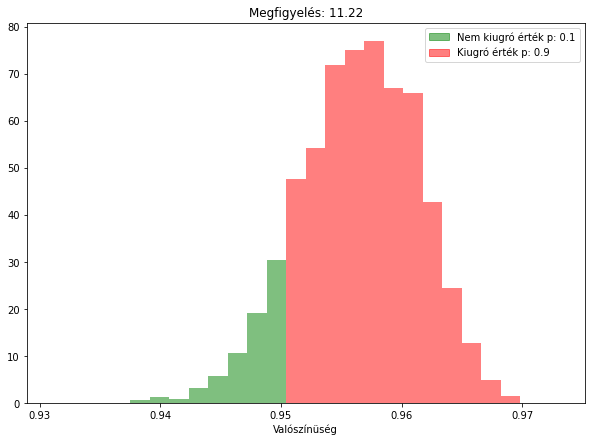

In [10]:
data = models
# a teljes valoszinüsége, hogy kiugró érték a megfigyelés
outlier_p = np.sum([ 1 if i >= alarmpoint else 0 for i in models])/len(models)

# oszlopok
binamount = 25
step = (max(data)-min(data))/binamount
binslabels = [ min(data)+s*step for s in range(binamount+2) ]
# súlyok
weights = np.ones_like(data)/float(len(data))
# plot
n, bins, patches = plt.hist(data, density=True, bins = binslabels , weights=weights)
# histogram szinezése
import matplotlib.patches as mpatches
for c, p in zip(bins, patches):
    if c>=alarmpoint:
        plt.setp(p, 'facecolor', 'red', alpha=0.5)
    else:
        plt.setp(p, 'facecolor', 'green', alpha=0.5)
handles = []
handles.append(mpatches.Patch(color='green', label=f"Nem kiugró érték p: {np.round(1-outlier_p, 2)}", alpha=0.5))
handles.append(mpatches.Patch(color='red', label=f"Kiugró érték p: {np.round(outlier_p, 2)}", alpha=0.5))      
plt.legend(handles=handles)
plt.title(f"Megfigyelés: {np.round(observation, 2)}")
plt.xlabel("Valószínüség")
plt.show()

# Truncated data

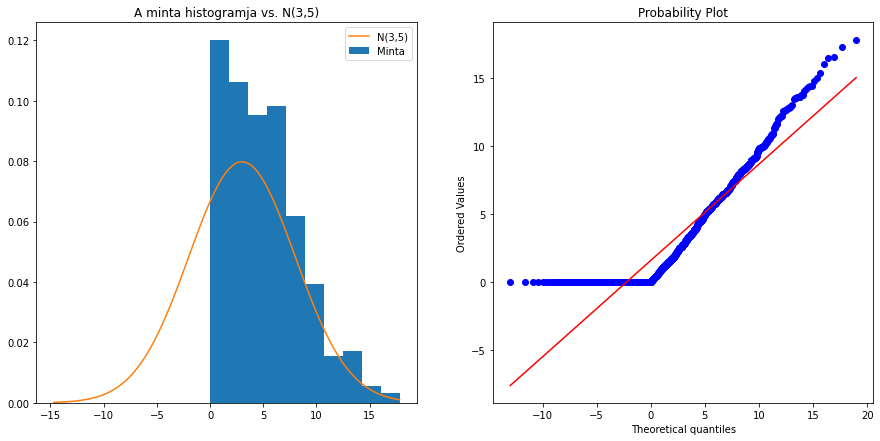

In [16]:
# truncated data
trunceted = np.array([ i for i in normal if i > low ])
# Histogram 
plt.subplot(1,2,1)
# minta
plt.hist(trunceted, density=True, label="Minta")
# standard normál pdf sűrűségfüggvénye 
bins = np.linspace(np.min(normal), np.max(normal), 100)
normalpdf = stats.norm.pdf(bins, true_mu, true_sigma)
plt.plot(bins, normalpdf, label=f"N({true_mu},{true_sigma})")
# jelmagyarázat és cím
plt.title(f"A minta histogramja vs. N({true_mu},{true_sigma})")
plt.legend()
 
# Q-Q ábra
plt.subplot(1,2,2)
stats.probplot(censored, dist="norm", sparams=(true_mu,true_sigma), plot=plt)
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\attila_sajo\miniconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1302 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7183423967137095, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


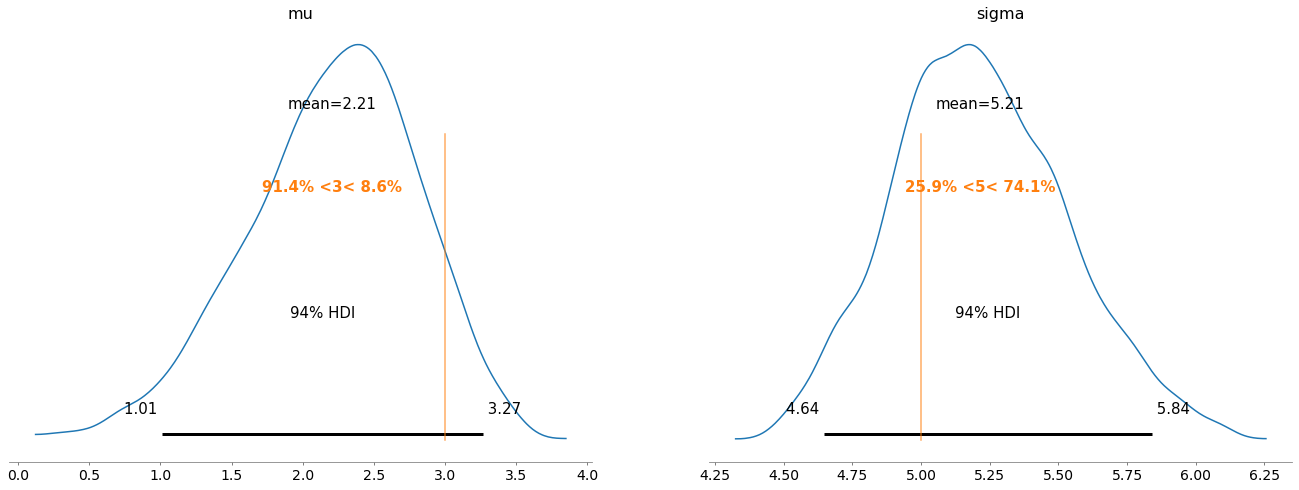

In [12]:

with pm.Model() as truncated_model:
    mu = pm.Uniform("mu", low, high)
    sigma = pm.Uniform("sigma", np.sqrt(np.var(uncensored))/2, 2*np.sqrt(np.var(uncensored)))
    N = pm.TruncatedNormal('N', mu=mu,sd=sigma,lower=low, observed = trunceted)
    
with truncated_model:
    trace = pm.sample(1000, tune=500, return_inferencedata=True)
    az.plot_posterior(trace, var_names=["mu", "sigma"], ref_val=[true_mu, true_sigma], round_to=3)